In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap

from gensim.models import KeyedVectors

from collections import Counter

In [ ]:
%run helper_functions

In [ ]:
data_path = "./data/"

data_speech1 = pd.read_parquet(data_path + 'data_speech1.parquet')
data_speech2 = pd.read_parquet(data_path + 'data_speech2.parquet')
data_speech3 = pd.read_parquet(data_path + 'data_speech3.parquet')
data_speech1_tok = pd.read_parquet(data_path+'data_speech1_tok.parquet')
data_speech2_tok = pd.read_parquet(data_path+'data_speech2_tok.parquet')

dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)
dspeech_tok = pd.concat([data_speech1_tok, data_speech2_tok], axis=0)

In [ ]:
C_words = pd.read_parquet(data_path+'final_C_words.parquet')
C_word_set = set(C_words['word'])

In [ ]:
MODEL_FILE = 'dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
model = KeyedVectors.load_word2vec_format(data_path+MODEL_FILE, binary=True)

In [ ]:
dspeech_C = pd.merge(dspeech_tok, dspeech.loc[dspeech.label=="C", ["meeting_id", "agenda_item_id", "speech_item_id", "label"]], on=["meeting_id", "agenda_item_id", "speech_item_id"], how="right")
dspeech_C = add_custom_features(dspeech_C, C_word_set, model)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


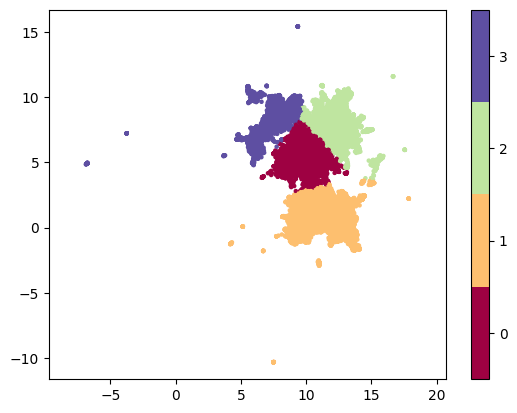

In [52]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(dspeech_C['average_vec_C'].tolist())

kmeans = KMeans(n_clusters=4, random_state=42).fit(embedding)

plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_, cmap='Spectral', s=5)

plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))

plt.savefig(data_path+'SI_C_Kmeans.svg', format='svg')

In [ ]:
dspeech_C["kmeans_group"] = kmeans.labels_
dspeech_C

,meeting_id,agenda_item_id,speech_item_id,speech_item_tokenized,label,C_counts,C_words,average_vec_C,kmeans_group
0,1,12,16,"[selvfølgelig, holdninger, putter, munden, sik...",C,4,"[fødevaresikkerhed, fremtidige, fødevaresikker...","[-0.24530156, -0.22133857, 0.03335177, 0.04360...",3
1,3,23,4,"[målsætning, nævnte, spørgsmål, markant, reduk...",C,2,"[målsætning, reduktion]","[-0.08730223, 0.02628037, -0.040816706, -0.341...",0
2,4,17,2,"[set, række, grunde, tager, ordet, vedrørende,...",C,59,"[frederikssundmotorvejen, udlægge, linjeføring...","[-0.08858074, -0.03556396, -0.025525484, -0.15...",1
3,4,29,2,"[enhedslisten, fremsat, forslag, indeholder, o...",C,61,"[trafikinvesteringer, frederikssundsfingeren, ...","[-0.12559205, -0.02918189, 0.004435317, -0.108...",1
4,4,29,4,"[spændende, transportministerens, svar, begrun...",C,9,"[strategisk, transportbehovene, frederikssundm...","[-0.21887714, 0.003830077, 0.009449156, -0.185...",1
...,...,...,...,...,...,...,...,...,...
27841,1787,8,3,"[oplyse, fru, pia, olsen, dyhr, truffet, beslu...",C,2,"[biler, klimatopmødet]","[-0.063023694, -0.13380815, 0.1066272, -0.0691...",1
27842,1787,8,7,"[indgår, faktisk, central, del, forberedelse, ...",C,9,"[klimatopmødet, klimavenligt, grønt, transport...","[-0.13249558, -0.010871007, -0.09819408, -0.14...",1
27843,1787,8,9,"[udenrigsministeriets, logistiske, planer, kli...",C,11,"[planer, klimatopmødet, topmødet, prioritetern...","[-0.17557298, -0.13215004, 0.07600329, 0.01904...",1
27844,1787,8,11,"[bare, faktisk, helt, central, bestræbelse, si...",C,12,"[klimakonference, transport, klimabelastende, ...","[-0.117049694, -0.00021328467, -0.0044141035, ...",1


In [ ]:
dspeech_0 = dspeech_C[dspeech_C['kmeans_group']==0]
dspeech_1 = dspeech_C[dspeech_C['kmeans_group']==1]
dspeech_2 = dspeech_C[dspeech_C['kmeans_group']==2]
dspeech_3 = dspeech_C[dspeech_C['kmeans_group']==3]

unique_words_0_list = [word for tokens in dspeech_0.C_words for word in tokens]
unique_words_1_list = [word for tokens in dspeech_1.C_words for word in tokens]
unique_words_2_list = [word for tokens in dspeech_2.C_words for word in tokens]
unique_words_3_list = [word for tokens in dspeech_3.C_words for word in tokens]

unique_words_0_dict = Counter(unique_words_0_list)
unique_words_1_dict = Counter(unique_words_1_list)
unique_words_2_dict = Counter(unique_words_2_list)
unique_words_3_dict = Counter(unique_words_3_list)

unique_words_0_df = pd.DataFrame.from_dict(unique_words_0_dict, orient='index', columns=['word_count_0']).reset_index().rename(columns={'index': 'word'})
unique_words_1_df = pd.DataFrame.from_dict(unique_words_1_dict, orient='index', columns=['word_count_1']).reset_index().rename(columns={'index': 'word'})
unique_words_2_df = pd.DataFrame.from_dict(unique_words_2_dict, orient='index', columns=['word_count_2']).reset_index().rename(columns={'index': 'word'})
unique_words_3_df = pd.DataFrame.from_dict(unique_words_3_dict, orient='index', columns=['word_count_3']).reset_index().rename(columns={'index': 'word'})

#merge
merged_df = pd.merge(unique_words_0_df, unique_words_1_df, on='word', how='outer')
merged_df = pd.merge(merged_df, unique_words_2_df, on='word', how='outer')
unique_words = pd.merge(merged_df, unique_words_3_df, on='word', how='outer')

unique_words[['word_count_0', 'word_count_1', 'word_count_2', 'word_count_3']] = unique_words[['word_count_0', 'word_count_1', 'word_count_2', 'word_count_3']].fillna(0)
unique_words['frequency_0'] = unique_words['word_count_0'] / sum(unique_words['word_count_0'])
unique_words['frequency_0_rest'] = (unique_words['word_count_1'] + unique_words['word_count_2'] + unique_words['word_count_3'])/(sum(unique_words['word_count_1']) + sum(unique_words['word_count_2']) + sum(unique_words['word_count_3']))
unique_words['frequency_1'] = unique_words['word_count_1'] / sum(unique_words['word_count_1'])
unique_words['frequency_1_rest'] = (unique_words['word_count_0'] + unique_words['word_count_2'] + unique_words['word_count_3'])/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_2']) + sum(unique_words['word_count_3']))
unique_words['frequency_2'] = unique_words['word_count_2'] / sum(unique_words['word_count_2'])
unique_words['frequency_2_rest'] = (unique_words['word_count_0'] + unique_words['word_count_1'] + unique_words['word_count_3'])/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_1']) + sum(unique_words['word_count_3']))
unique_words['frequency_3'] = unique_words['word_count_3'] / sum(unique_words['word_count_3'])
unique_words['frequency_3_rest'] = (unique_words['word_count_0'] + unique_words['word_count_1'] + unique_words['word_count_2'])/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_1']) + sum(unique_words['word_count_2']))
freq_1_0 = 1/(sum(unique_words['word_count_1']) + sum(unique_words['word_count_2']) + sum(unique_words['word_count_3']))
freq_1_1 = 1/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_2']) + sum(unique_words['word_count_3']))
freq_1_2 = 1/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_1']) + sum(unique_words['word_count_3']))
freq_1_3 = 1/(sum(unique_words['word_count_0']) + sum(unique_words['word_count_1']) + sum(unique_words['word_count_2']))

unique_words["odds_0"] = unique_words.apply(lambda row: calculate_custom_odds(row['frequency_0'], row['frequency_0_rest'], freq_1_0), axis=1)
unique_words["odds_1"] = unique_words.apply(lambda row: calculate_custom_odds(row['frequency_1'], row['frequency_1_rest'], freq_1_1), axis=1)
unique_words["odds_2"] = unique_words.apply(lambda row: calculate_custom_odds(row['frequency_2'], row['frequency_2_rest'], freq_1_2), axis=1)
unique_words["odds_3"] = unique_words.apply(lambda row: calculate_custom_odds(row['frequency_3'], row['frequency_3_rest'], freq_1_3), axis=1)

In [34]:
unique_words.sort_values("odds_0", ascending=False)[0:20]

,word,word_count_0,word_count_1,word_count_2,word_count_3,frequency_0,frequency_0_rest,frequency_1,frequency_1_rest,frequency_2,frequency_2_rest,frequency_3,frequency_3_rest,odds_0,odds_1,odds_2,odds_3
521,accord,45.0,0.0,0.0,0.0,0.000349,0.000000,0.000000,0.000099,0.000000,0.000106,0.000000,0.000118,152.415615,0.000000,0.000000,0.000000
2776,børsnotering,29.0,0.0,0.0,0.0,0.000225,0.000000,0.000000,0.000064,0.000000,0.000069,0.000000,0.000076,98.223396,0.000000,0.000000,0.000000
1099,udviklingssamarbejdet,28.0,0.0,0.0,0.0,0.000217,0.000000,0.000000,0.000062,0.000000,0.000066,0.000000,0.000073,94.836383,0.000000,0.000000,0.000000
2928,klimafinansiering,27.0,1.0,0.0,0.0,0.000210,0.000002,0.000009,0.000059,0.000000,0.000066,0.000000,0.000073,91.449369,0.151026,0.000000,0.000000
1512,verdensøkonomien,25.0,0.0,0.0,1.0,0.000194,0.000002,0.000000,0.000057,0.000000,0.000061,0.000005,0.000065,84.675342,0.000000,0.000000,0.083883
982,krisepolitik,22.0,0.0,0.0,0.0,0.000171,0.000000,0.000000,0.000048,0.000000,0.000052,0.000000,0.000057,74.514301,0.000000,0.000000,0.000000
557,ilandene,22.0,0.0,1.0,0.0,0.000171,0.000002,0.000000,0.000051,0.000007,0.000052,0.000000,0.000060,74.514301,0.000000,0.134756,0.000000
5436,robotter,19.0,0.0,1.0,0.0,0.000147,0.000002,0.000000,0.000044,0.000007,0.000045,0.000000,0.000052,64.353260,0.000000,0.156033,0.000000
1617,klimadiplomati,19.0,0.0,1.0,0.0,0.000147,0.000002,0.000000,0.000044,0.000007,0.000045,0.000000,0.000052,64.353260,0.000000,0.156033,0.000000
3599,verdensmålene,55.0,0.0,1.0,2.0,0.000427,0.000007,0.000000,0.000128,0.000007,0.000135,0.000011,0.000146,62.095251,0.000000,0.052011,0.074896


In [35]:
unique_words.sort_values("odds_1", ascending=False)[0:20]

,word,word_count_0,word_count_1,word_count_2,word_count_3,frequency_0,frequency_0_rest,frequency_1,frequency_1_rest,frequency_2,frequency_2_rest,frequency_3,frequency_3_rest,odds_0,odds_1,odds_2,odds_3
6159,trængslen,1.0,89.0,0.0,0.0,0.000008,0.000204,0.000799,0.000002,0.000000,0.000213,0.000000,0.000235,0.038056,362.915757,0.000000,0.000000
13390,dobbeltspor,0.0,61.0,0.0,0.0,0.000000,0.000140,0.000548,0.000000,0.000000,0.000144,0.000000,0.000159,0.000000,248.740013,0.000000,0.000000
13834,havnetunnel,0.0,56.0,0.0,1.0,0.000000,0.000131,0.000503,0.000002,0.000000,0.000135,0.000005,0.000146,0.000000,228.351487,0.000000,0.037448
14388,dobbeltsporet,0.0,50.0,0.0,0.0,0.000000,0.000115,0.000449,0.000000,0.000000,0.000118,0.000000,0.000131,0.000000,203.885257,0.000000,0.000000
13578,partikelfilter,0.0,150.0,1.0,2.0,0.000000,0.000351,0.001347,0.000007,0.000007,0.000360,0.000011,0.000394,0.000000,203.885257,0.019504,0.027776
13637,emballageafgiften,0.0,49.0,0.0,0.0,0.000000,0.000112,0.000440,0.000000,0.000000,0.000116,0.000000,0.000128,0.000000,199.807551,0.000000,0.000000
13512,fremkommelighed,0.0,47.0,0.0,1.0,0.000000,0.000110,0.000422,0.000002,0.000000,0.000114,0.000005,0.000123,0.000000,191.652141,0.000000,0.044619
13402,infrastrukturkommissionen,0.0,45.0,0.0,0.0,0.000000,0.000103,0.000404,0.000000,0.000000,0.000106,0.000000,0.000118,0.000000,183.496731,0.000000,0.000000
13554,vejprojekter,0.0,45.0,0.0,0.0,0.000000,0.000103,0.000404,0.000000,0.000000,0.000106,0.000000,0.000118,0.000000,183.496731,0.000000,0.000000
13421,trafikstøj,0.0,43.0,0.0,1.0,0.000000,0.000101,0.000386,0.000002,0.000000,0.000104,0.000005,0.000112,0.000000,175.341321,0.000000,0.048769


In [36]:
unique_words.sort_values("odds_2", ascending=False)[0:20]

,word,word_count_0,word_count_1,word_count_2,word_count_3,frequency_0,frequency_0_rest,frequency_1,frequency_1_rest,frequency_2,frequency_2_rest,frequency_3,frequency_3_rest,odds_0,odds_1,odds_2,odds_3
20305,pristillæg,0.0,0.0,58.0,0.0,0.000000,0.000133,0.000000,0.000128,0.000407,0.000000,0.000000,0.000152,0.000000,0.000000,171.948501,0.000000
11314,forsyningstilsynet,1.0,0.0,48.0,0.0,0.000008,0.000110,0.000000,0.000108,0.000337,0.000002,0.000000,0.000128,0.070563,0.000000,142.302208,0.000000
6820,sugar,1.0,0.0,47.0,0.0,0.000008,0.000108,0.000000,0.000106,0.000330,0.000002,0.000000,0.000125,0.072064,0.000000,139.337578,0.000000
13092,kullene,1.0,0.0,47.0,0.0,0.000008,0.000108,0.000000,0.000106,0.000330,0.000002,0.000000,0.000125,0.072064,0.000000,139.337578,0.000000
20730,målere,0.0,0.0,45.0,0.0,0.000000,0.000103,0.000000,0.000099,0.000316,0.000000,0.000000,0.000118,0.000000,0.000000,133.408320,0.000000
21486,energinets,0.0,0.0,45.0,0.0,0.000000,0.000103,0.000000,0.000099,0.000316,0.000000,0.000000,0.000118,0.000000,0.000000,133.408320,0.000000
12354,megawatt,1.0,0.0,41.0,0.0,0.000008,0.000094,0.000000,0.000093,0.000288,0.000002,0.000000,0.000110,0.082610,0.000000,121.549802,0.000000
20687,energitilsynet,0.0,0.0,40.0,0.0,0.000000,0.000092,0.000000,0.000088,0.000280,0.000000,0.000000,0.000104,0.000000,0.000000,118.585173,0.000000
21479,forsøgsmøller,0.0,0.0,34.0,0.0,0.000000,0.000078,0.000000,0.000075,0.000238,0.000000,0.000000,0.000089,0.000000,0.000000,100.797397,0.000000
1454,landvindmøller,2.0,0.0,68.0,0.0,0.000016,0.000156,0.000000,0.000154,0.000477,0.000005,0.000000,0.000183,0.099618,0.000000,100.797397,0.000000


In [37]:
unique_words.sort_values("odds_3", ascending=False)[0:20]

,word,word_count_0,word_count_1,word_count_2,word_count_3,frequency_0,frequency_0_rest,frequency_1,frequency_1_rest,frequency_2,frequency_2_rest,frequency_3,frequency_3_rest,odds_0,odds_1,odds_2,odds_3
25849,glyfosat,0.0,0.0,0.0,288.0,0.000000,0.000660,0.000000,0.000634,0.000000,0.000681,0.001578,0.000000,0.000000,0.000000,0.000000,603.959113
25814,randzonerne,0.0,0.0,0.0,256.0,0.000000,0.000586,0.000000,0.000564,0.000000,0.000606,0.001402,0.000000,0.000000,0.000000,0.000000,536.852545
1197,gmo,1.0,0.0,0.0,180.0,0.000008,0.000412,0.000000,0.000399,0.000000,0.000428,0.000986,0.000003,0.018817,0.000000,0.000000,377.474445
17097,havbrug,0.0,2.0,0.0,316.0,0.000000,0.000729,0.000018,0.000696,0.000000,0.000752,0.001731,0.000005,0.000000,0.025808,0.000000,331.338680
10130,efterafgrøder,2.0,0.0,0.0,259.0,0.000016,0.000593,0.000000,0.000575,0.000000,0.000617,0.001419,0.000005,0.026155,0.000000,0.000000,271.571893
25846,roundup,0.0,0.0,0.0,121.0,0.000000,0.000277,0.000000,0.000267,0.000000,0.000286,0.000663,0.000000,0.000000,0.000000,0.000000,253.746710
12317,pesticidrester,1.0,0.0,0.0,120.0,0.000008,0.000275,0.000000,0.000267,0.000000,0.000286,0.000657,0.000003,0.028225,0.000000,0.000000,251.649630
7706,græssere,1.0,0.0,0.0,106.0,0.000008,0.000243,0.000000,0.000236,0.000000,0.000253,0.000581,0.000003,0.031953,0.000000,0.000000,222.290507
2715,økologerne,1.0,0.0,0.0,105.0,0.000008,0.000241,0.000000,0.000233,0.000000,0.000251,0.000575,0.000003,0.032257,0.000000,0.000000,220.193426
26064,invasive,0.0,0.0,0.0,97.0,0.000000,0.000222,0.000000,0.000214,0.000000,0.000229,0.000531,0.000000,0.000000,0.000000,0.000000,203.416784


In [40]:
dspeech_C.kmeans_group.value_counts()

3    8849
0    7180
2    6501
1    5316
Name: kmeans_group, dtype: int64

In [47]:
dspeech_C["speech_item_tokenized"] = dspeech_C["speech_item_tokenized"].apply(lambda x: str(x))
dspeech_C[["meeting_id", "agenda_item_id", "speech_item_id", "speech_item_tokenized", "kmeans_group"]].to_parquet(data_path+'data_speech_C.parquet')

In [49]:
unique_words[["word", "word_count_0", "word_count_1", "word_count_2", "word_count_3", "odds_0", "odds_1", "odds_2", "odds_3"]].to_parquet(data_path+'unique_words_C.parquet')